In [ ]:
#!pip install mambapy

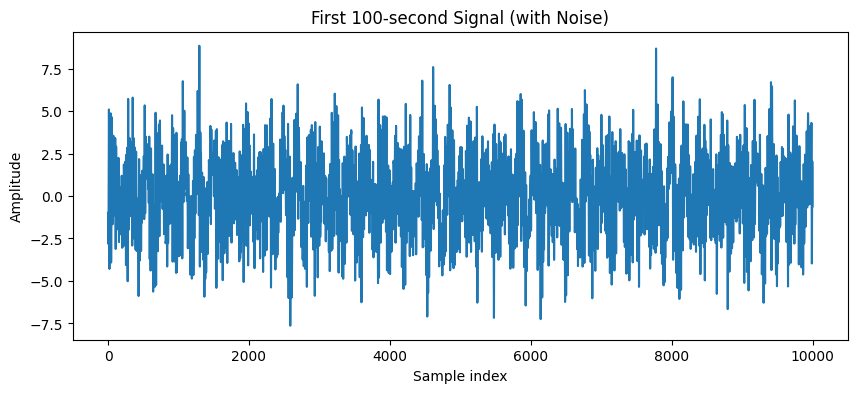

In [ ]:
import torch
import matplotlib.pyplot as plt  # Optional, for plotting

# Parameters
T = 100              # Duration of each signal in seconds
Fs = 100             # Sampling frequency (Hz)
num_samples = int(T * Fs)  # Total samples per signal (100 * 100 = 10,000)
num_sinusoids = 10   # Number of sinusoids to mix
noise_std = 0.1      # Standard deviation of the Gaussian noise
n = 5                # Number of independent signals to generate

# Create a time vector for one signal.
# We use torch.arange to avoid including the endpoint.
t = torch.arange(0, T, 1.0 / Fs)  # Shape: (num_samples,)

# --- Vectorized generation for n signals ---
# For each signal we will have num_sinusoids random frequencies and phases.
# Generate random frequencies in [0.1, 10] Hz and phases in [0, 2*pi]
freqs = (10 - 0.1) * torch.rand(n, num_sinusoids) + 0.1   # Shape: (n, num_sinusoids)
phases = 2 * torch.pi * torch.rand(n, num_sinusoids)         # Shape: (n, num_sinusoids)

# To add the sinusoids, we need to broadcast over the time vector.
# Reshape t to (1, 1, num_samples) so that it broadcasts correctly:
t = t.unsqueeze(0).unsqueeze(0)       # New shape: (1, 1, num_samples)
# Also reshape freqs and phases to have a trailing singleton dimension:
freqs = freqs.unsqueeze(-1)           # Shape becomes (n, num_sinusoids, 1)
phases = phases.unsqueeze(-1)         # Shape becomes (n, num_sinusoids, 1)

# Now compute each sinusoid: sin(2*pi*frequency*t + phase)
# The result has shape (n, num_sinusoids, num_samples)
sinusoids = torch.sin(2 * torch.pi * freqs * t + phases)

# Sum over the sinusoids dimension to create one composite signal per sample:
signals = sinusoids.sum(dim=1)        # Shape: (n, num_samples)

# Add Gaussian noise to each signal:
signals = signals + noise_std * torch.randn(n, num_samples)

# Option 1: Keep the signals as separate rows (each of length 10,000):
signals_stacked = signals           # Tensor of shape (n, num_samples)

# Option 2: Concatenate all signals into one long signal (of length n*num_samples)
long_signal = signals.view(-1)      # Tensor of shape (n*num_samples,)

# --- (Optional) Plot the first signal ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(signals_stacked[0].numpy())
plt.title("First 100-second Signal (with Noise)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.show()

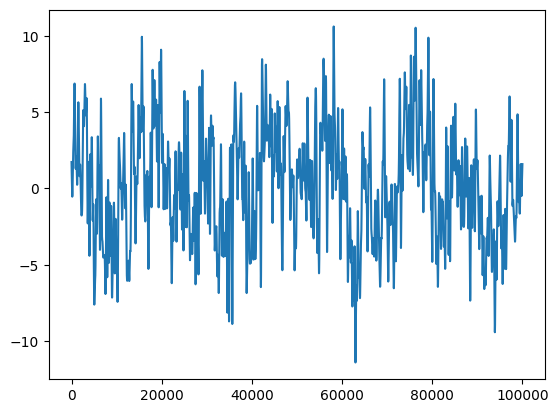

In [1]:
import matplotlib.pyplot as plt  # Optional, for plotting
import torch

def gen_signal(T_tot, T, Fs, num_sinusoids, noise_std, n):
    # Total time becomes the input T_tot plus the forecast duration T
    T_tot = T_tot + T
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Time vector (all computations done on GPU)
    t = torch.arange(0, T_tot, 1.0 / Fs, device=device)  # shape: (N,)
    N = t.numel()

    # Length of the window corresponding to duration T
    L = int(T * Fs)
    window = torch.bartlett_window(L, device=device)

    # Generate random parameters for all sinusoids (vectorized)
    # Random start time for each sinusoid (in seconds)
    t_start = torch.rand(num_sinusoids, device=device) * T_tot
    n_start = (t_start * Fs).long()  # start indices in the time vector
    n_end = torch.clamp(n_start + L, max=N)  # each sinusoid lasts L samples or less if near end

    # Frequencies: drawn from a log-uniform distribution between 10^(-2) and 10
    freq = 10 ** (torch.rand(num_sinusoids, device=device) * 2 - 2.5)
    # Phases and amplitudes
    phase = 2 * torch.pi * torch.rand(num_sinusoids, device=device)
    amp = torch.rand(num_sinusoids, device=device)

    # Compute the base sinusoids for all sinusoids at once.
    # Expand dimensions so that:
    # - freq, phase, amp are shape (num_sinusoids, 1)
    # - t is shape (1, N)
    S = amp[:, None] * torch.sin(2 * torch.pi * freq[:, None] * t[None, :] + phase[:, None])

    # Build a window weight for each sinusoid. For each sinusoid i,
    # we want to multiply S[i, :] by the bartlett window for indices between n_start[i] and n_end[i],
    # and zero out the rest.
    # Create a row vector of indices
    idx = torch.arange(N, device=device).expand(num_sinusoids, N)  # shape: (num_sinusoids, N)
    # Compute relative index with respect to each sinusoid's start
    rel_idx = idx - n_start[:, None]
    # Create a mask that is True only for indices within [n_start, n_end)
    valid = (idx >= n_start[:, None]) & (idx < n_end[:, None])
    # For indexing the window, clamp the relative indices to the valid range of the window.
    rel_idx_clamped = torch.clamp(rel_idx, 0, L - 1)
    # Get window values for each position (the same window is used for all sinusoids)
    window_vals = window[rel_idx_clamped]
    # Apply the mask so that positions outside the active region become zero.
    weights = window_vals * valid.float()

    # Apply the window to the sinusoids signal
    S = S * weights

    # Add noise (vectorized)
    noise = noise_std * torch.randn(num_sinusoids, N, device=device)
    S = S + noise

    # Sum over all sinusoids to get the final signal
    signal = S.sum(dim=0)

    # Remove the first L samples to mimic the original code
    signal = signal[L:]
    return signal.cpu()


H = 1
T_tot = 1000
T = 300
Fs = 100
num_sinusoids = 1000
noise_std = 0.00
n = 5
X = gen_signal(T_tot, T, Fs, num_sinusoids, noise_std, n)
plt.plot(X)

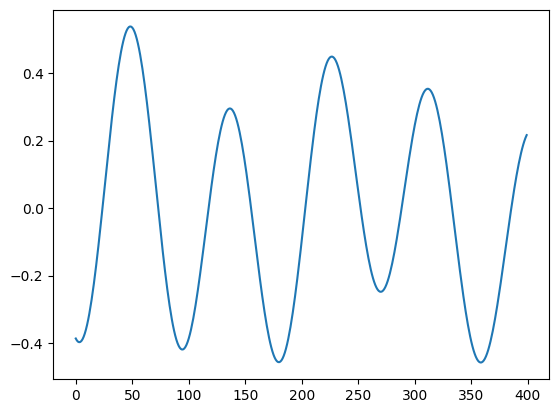

In [34]:
import random
class dataloader:
    def __init__(self, T_tot, T, Fs, num_sinusoids, noise_std, n, B, L, D, dur, H):
        self.T_tot = T_tot
        self.T = T
        self.Fs = Fs
        self.num_sinusoids = num_sinusoids
        self.noise_std = noise_std
        self.n = n
        self.B = B
        self.L = L
        self.D = D
        self.dur = dur
        self.H = H
        self.reset()

    def reset(self):
        self.X = gen_signal(self.T_tot, self.T, self.Fs, self.num_sinusoids, self.noise_std, self.n)
        self.step = 0

    def next_batch(self, H=None):
        B, L = self.B, self.L
        if H is None:
            H = self.H
        ind = random.randint(0, self.X.numel() - B*L - 1 - H)
        buf = self.X[ind: ind + B*L + H]
        x = (buf[:-H]).view(B, L) # inputs
        y = (buf[H:]).view(B, L) # targets
        # advance the position in the tensor
        x = x.unsqueeze(2)
        y = y.unsqueeze(2)
        self.step += 1
        if self.step >= self.dur:
            self.reset()
        return x, y


H = 1
T_tot = 12000
T = 400
Fs = 10
num_sinusoids = 90
noise_std = 0.00
n = 5
B = 256
L = 400
D = 1
dur = 10
train_dataloader = dataloader(T_tot, T, Fs, num_sinusoids, noise_std, n, B, L, D, dur, H)
x, y = train_dataloader.next_batch()
#test_dataloader = dataloader(T_tot, T, Fs, num_sinusoids, noise_std, n, B, L, D)
plt.plot(torch.squeeze(x[0,:,0]))

In [ ]:
x.shape, y.shape

(torch.Size([48, 2000, 1]), torch.Size([48, 2000, 1]))

In [ ]:
"""
import torch
from mambapy.mamba import Mamba, MambaConfig
from tqdm import tqdm
import wandb
import random
# Initialize wandb (customize the project and run names as needed)
wandb.login(key="97c5ccce40a3d70a8812e2ff262325923b21a9c8")
wandb.init(project="mamba", name="experimental_m2")

num_steps = 3000

# Set up the model and optimizer
config = MambaConfig(d_model=1, n_layers=2, expand_factor=256, inner_layernorms=True, bias=True)#, mup_base_width=256)
model = Mamba(config)
model.to('cuda')
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.MSELoss()

# Training loop with tqdm progress bar logging loss and reporting to wandb.
pbar = tqdm(range(num_steps), desc="Training", unit="step")
for step in pbar:
    # Get a batch from your dataloader (assumed to have a .next_batch() method)
    H = random.randint(1, 1)
    x, y = train_dataloader.next_batch(H=H)
    x = x.to('cuda')
    y = y.to('cuda')
    y = y[:,-1,:]

    # Forward pass
    for _ in range(H):
      y_pred = model(x)
      x = torch.cat([x[:,1:,:], y_pred[:,-1,:].unsqueeze(1)], dim=1)
    y_pred = y_pred[:,-1,:]
    loss = loss_fn(y_pred, y)

    # Backward pass and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the loss (and step if desired) to wandb
    wandb.log({"loss": loss.item(), "step": step})

    # Update the progress bar postfix with the latest loss
    pbar.set_postfix(loss=loss.item(), H=H)
"""

'\nimport torch\nfrom mambapy.mamba import Mamba, MambaConfig\nfrom tqdm import tqdm\nimport wandb\nimport random\n# Initialize wandb (customize the project and run names as needed)\nwandb.login(key="97c5ccce40a3d70a8812e2ff262325923b21a9c8")\nwandb.init(project="mamba", name="experimental_m2")\n\nnum_steps = 3000\n\n# Set up the model and optimizer\nconfig = MambaConfig(d_model=1, n_layers=2, expand_factor=256, inner_layernorms=True, bias=True)#, mup_base_width=256)\nmodel = Mamba(config)\nmodel.to(\'cuda\')\nmodel.train()\n\noptimizer = torch.optim.Adam(model.parameters(), lr=0.005)\nloss_fn = torch.nn.MSELoss()\n\n# Training loop with tqdm progress bar logging loss and reporting to wandb.\npbar = tqdm(range(num_steps), desc="Training", unit="step")\nfor step in pbar:\n    # Get a batch from your dataloader (assumed to have a .next_batch() method)\n    H = random.randint(1, 1)\n    x, y = train_dataloader.next_batch(H=H)\n    x = x.to(\'cuda\')\n    y = y.to(\'cuda\')\n    y = y[:,-1

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from tqdm import tqdm

# Enable cudnn autotuner for optimal performance.
torch.backends.cudnn.benchmark = True

# -------------------------
# RevIN Module
# -------------------------
class RevIN(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        """
        RevIN (Reversible Instance Normalization) normalizes the input instance-wise
        and provides an inverse operation to restore the original scale.
        Args:
            num_features: number of features/channels in the input (e.g. input_dim).
            eps: a small number to avoid division by zero.
            affine: whether to use learnable scale and shift.
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self.weight = nn.Parameter(torch.ones(1, 1, num_features))
            self.bias = nn.Parameter(torch.zeros(1, 1, num_features))

    def forward(self, x):
        # x shape: (B, L, C)
        # Compute per-instance mean and std over the time dimension.
        self.mean = x.mean(dim=1, keepdim=True)
        self.std = x.std(dim=1, keepdim=True)
        x_norm = (x - self.mean) / (self.std + self.eps)
        if self.affine:
            x_norm = x_norm * self.weight + self.bias
        return x_norm

    def inverse(self, x):
        # Reverse the normalization using the stored mean and std.
        if self.affine:
            x = (x - self.bias) / self.weight
        x_denorm = x * (self.std + self.eps) + self.mean
        return x_denorm

# -------------------------
# Positional Encoding Module
# -------------------------
class ConcatPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=2000):
        super(ConcatPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        pos_enc = self.pe[:, :seq_len, :].expand(x.size(0), seq_len, self.d_model)
        # Concatenate the positional encoding along the last dimension.
        x = torch.cat([x, pos_enc], dim=-1)  # shape: (B, L, 2*d_model)
        return self.dropout(x)

# -------------------------
# Custom Flash Multihead Attention Module
# -------------------------
class FlashMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, attn_mask=None):
        B, L, E = query.size()
        # Project and reshape for multi-head: (B, L, num_heads, head_dim) then transpose to (B, num_heads, L, head_dim)
        q = self.q_proj(query).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        # Use PyTorch's built-in scaled_dot_product_attention which leverages flash attention if possible.
        # Setting is_causal=True enforces a causal mask.
        attn_output = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask,
                                                     dropout_p=self.dropout, is_causal=True)
        # Reshape back to (B, L, E)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, E)
        return self.out_proj(attn_output)

# -------------------------
# Custom Transformer Encoder Layer using Flash Attention
# -------------------------
class FlashTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        self.self_attn = FlashMultiheadAttention(d_model, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()  # or ReLU if preferred

    def forward(self, src, src_mask=None):
        # Self-attention block; flash attention internally enforces causality.
        src2 = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        # Feed-forward block.
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

# -------------------------
# Transformer Time Series Model using Flash Attention and RevIN
# -------------------------
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim=1, model_dim=256, num_heads=8, num_layers=12, dropout=0.2, use_revin=True):
        """
        Args:
            input_dim: Dimensionality of the input time series.
            model_dim: Internal model dimension.
            num_heads: Number of attention heads.
            num_layers: Number of transformer encoder layers.
            dropout: Dropout probability.
            use_revin: If True, apply RevIN before the model and invert it at the output.
        """
        super(TransformerTimeSeries, self).__init__()
        self.use_revin = use_revin
        if self.use_revin:
            self.revin = RevIN(input_dim, affine=True)
        # Project input to model dimension.
        self.input_proj = nn.Linear(input_dim, model_dim)
        # Concatenate positional encodings.
        self.pos_encoder = ConcatPositionalEncoding(model_dim, dropout)
        # After concatenation, project back to model_dim.
        self.concat_proj = nn.Linear(2 * model_dim, model_dim)
        # Build a stack of custom encoder layers with flash attention.
        self.encoder_layers = nn.ModuleList([
            FlashTransformerEncoderLayer(d_model=model_dim,
                                         num_heads=num_heads,
                                         dim_feedforward=model_dim * 4,
                                         dropout=dropout)
            for _ in range(num_layers)
        ])
        # Final projection back to original input dimension.
        self.output_proj = nn.Linear(model_dim, input_dim)

    def forward(self, src):
        # Optionally apply RevIN normalization.
        if self.use_revin:
            src = self.revin(src)
        x = src  # Save the normalized input for the skip connection.
        src = self.input_proj(src)       # (B, L, model_dim)
        src = self.pos_encoder(src)        # (B, L, 2*model_dim)
        src = self.concat_proj(src)        # (B, L, model_dim)
        # Iteratively apply encoder layers.
        for layer in self.encoder_layers:
            src = layer(src)
        out = self.output_proj(src) + x    # Add the skip connection.
        # Optionally reverse the normalization to recover original scale.
        if self.use_revin:
            out = self.revin.inverse(out)
        return out


# -------------------------
# Weight Initialization Function
# -------------------------
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# -------------------------
# Instantiate, Initialize, and Compile the Model
# -------------------------
transformer_model = TransformerTimeSeries(input_dim=1, model_dim=128, num_heads=16, num_layers=3, dropout=0.2)
transformer_model.apply(init_weights)
transformer_model.to('cuda')
transformer_model.train()

# Compile the model using torch.compile (requires PyTorch 2.0+)
transformer_model = torch.compile(transformer_model)

total_params = sum(p.numel() for p in transformer_model.parameters())
print(f"The model has {total_params} parameters.")

lr = 0.001
optimizer_trans = torch.optim.Adam(transformer_model.parameters(), lr=lr)
loss_fn_trans = nn.MSELoss()

# -------------------------
# Training Loop with Mixed Precision
# -------------------------
# (Assuming a dataloader function is defined elsewhere that provides batches.)
transformer_dataloader = dataloader(T_tot, T, Fs, num_sinusoids, noise_std, n, B, L, D, dur, H)

num_steps_trans = 5000
wandb.login(key="97c5ccce40a3d70a8812e2ff262325923b21a9c8")
wandb.init(project="mamba", name="experimental_t2")
pbar_trans = tqdm(range(num_steps_trans), desc="Transformer Training", unit="step")

scaler = torch.cuda.amp.GradScaler()  # for mixed precision training
c = 0
last = False
for step in pbar_trans:
    x_t, y_t = transformer_dataloader.next_batch()
    x_t = x_t.to('cuda')
    y_t = y_t.to('cuda')
    # Use only the last time step of y_t as in the original code.
    if last:
        y_t = y_t[:, -1, :]
    optimizer_trans.zero_grad()

    # Mixed precision forward pass.
    with torch.cuda.amp.autocast():
        y_pred_t = transformer_model(x_t)
        if last:
            y_pred_t = y_pred_t[:, -1, :]
        loss_t = loss_fn_trans(y_pred_t, y_t)

    scaler.scale(loss_t).backward()
    scaler.step(optimizer_trans)
    scaler.update()

    wandb.log({"transformer_loss": loss_t.item(), "step": step})
    pbar_trans.set_postfix(loss=loss_t.item())
    c += 1
    if c % 5000 == 0:
        lr = max(lr / 2, 0.00001)
        optimizer_trans = torch.optim.Adam(transformer_model.parameters(), lr=lr)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


The model has 628099 parameters.


Transformer Training:   0%|          | 0/5000 [00:00<?, ?step/s]<ipython-input-23-1f01c5b07dc4>:220: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # for mixed precision training
<ipython-input-23-1f01c5b07dc4>:233: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Transformer Training:   0%|          | 1/5000 [00:06<9:40:10,  6.96s/step, loss=0.16]<ipython-input-23-1f01c5b07dc4>:233: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Transformer Training: 100%|██████████| 5000/5000 [04:49<00:00, 17.26step/s, loss=0.000746]


In [ ]:
from datetime import time
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
%mkdir -p time_series_transformer
%cd time_series_transformer
torch.save(transformer_model, "transformer_full_model.pth")

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/time_series_transformer


In [ ]:
#%% [code]
# Define an autoregressive inference function.
def autoregressive_inference(model, seed, steps):
    """
    Generates autoregressive predictions using the given model.
    Args:
        model: A trained PyTorch model that expects input shape (B, L, D).
        seed: A tensor of shape (1, L, D) used as the starting input.
        steps: Number of time steps to predict.
    Returns:
        A tensor of shape (1, steps, D) containing the predicted values.
    """
    model.eval()  # switch model to evaluation mode
    predictions = []
    # Clone the seed so we don't modify the original
    input_seq = seed.clone()  # shape: (1, L, D)
    with torch.no_grad():
        for _ in range(steps):
            # Forward pass: predict the full sequence output.
            output = model(input_seq.to('cuda'))  # shape: (1, L, D)
            # Use the last time-step as our next prediction.
            next_val = output[:, -1:, :]  # shape: (1, 1, D)
            predictions.append(next_val.cpu())
            # Update the input sequence: drop the first time-step and append the new prediction.
            input_seq = torch.cat([input_seq[:, 1:, :].cpu(), next_val.cpu()], dim=1)
    # Concatenate predictions along the sequence dimension.
    return torch.cat(predictions, dim=1)  # shape: (1, steps, D)

# Set inference parameters.
seed_length = 2000           # Use the same sequence length as in training (e.g. 1000).
inference_steps = 500     # Number of autoregressive steps to predict.

# Generate a fresh synthetic signal for inference (using the same parameters).
ground_truth_signal = gen_signal(20000, T, Fs, num_sinusoids, noise_std, n)
ground_truth_signal = ground_truth_signal.detach().cpu()  # ensure tensor is on CPU

# Select a segment of the ground truth signal:
# Use the first `seed_length` points as the seed, and the next `inference_steps` points as ground truth.
seed = ground_truth_signal[:seed_length].unsqueeze(0).unsqueeze(2)  # shape: (1, seed_length, 1)
true_future = ground_truth_signal[seed_length:seed_length+inference_steps]

# Autoregressive inference for MAMBA.
#mamba_pred = autoregressive_inference(model, seed, inference_steps)  # shape: (1, inference_steps, 1)

# Autoregressive inference for the Transformer model.
transformer_pred = autoregressive_inference(transformer_model, seed, inference_steps)  # shape: (1, inference_steps, 1)

# For plotting, combine the seed with the predicted outputs.
# This shows how the predictions extend the given seed.
#mamba_full = torch.cat([seed.cpu(), mamba_pred], dim=1).squeeze(0).squeeze(1)         # shape: (seed_length + inference_steps)
transformer_full = torch.cat([seed.cpu(), transformer_pred], dim=1).squeeze(0).squeeze(1) # shape: (seed_length + inference_steps)
gt_full = ground_truth_signal[:seed_length+inference_steps]  # ground truth segment



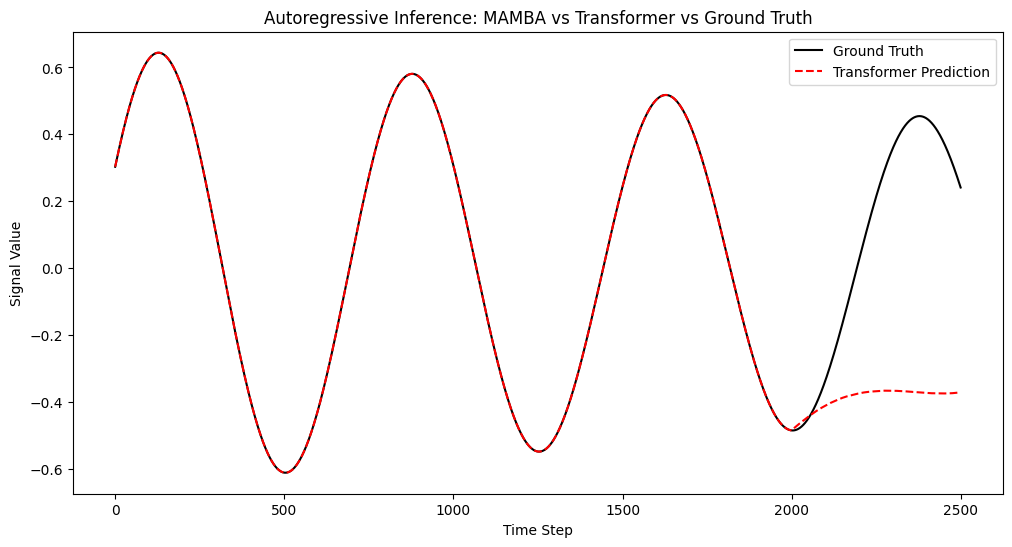

In [ ]:
# Plot the results.
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(gt_full.numpy(), label='Ground Truth', color='black')
#plt.plot(mamba_full.numpy(), label='MAMBA Prediction', linestyle='--', color='blue')
plt.plot(transformer_full.numpy(), label='Transformer Prediction', linestyle='--', color='red')
plt.title('Autoregressive Inference: MAMBA vs Transformer vs Ground Truth')
plt.xlabel('Time Step')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

In [ ]:
transformer_full[seed_length:]

In [ ]:

import matplotlib.pyplot as plt
import torch

def gen_signal(T_tot, T, Fs, num_sinusoids, noise_std, n):
    T_tot = T_tot + T
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t = torch.arange(0, T_tot, 1.0 / Fs, device=device)
    N = t.numel()
    L = int(T * Fs)
    window = torch.bartlett_window(L, device=device)
    t_start = torch.rand(num_sinusoids, device=device) * T_tot
    n_start = (t_start * Fs).long()
    n_end = torch.clamp(n_start + L, max=N)
    freq = 10 ** (torch.rand(num_sinusoids, device=device) * 2 - 2.5)
    phase = 2 * torch.pi * torch.rand(num_sinusoids, device=device)
    amp = torch.rand(num_sinusoids, device=device)
    S = amp[:, None] * torch.sin(2 * torch.pi * freq[:, None] * t[None, :] + phase[:, None])
    idx = torch.arange(N, device=device).expand(num_sinusoids, N)
    rel_idx = idx - n_start[:, None]
    valid = (idx >= n_start[:, None]) & (idx < n_end[:, None])
    rel_idx_clamped = torch.clamp(rel_idx, 0, L - 1)
    window_vals = window[rel_idx_clamped]
    weights = window_vals * valid.float()
    S = S * weights
    noise = noise_std * torch.randn(num_sinusoids, N, device=device)
    S = S + noise
    signal = S.sum(dim=0)
    signal = signal[L:]
    return signal.cpu()


import random
class dataloader:
    def __init__(self, T_tot, T, Fs, num_sinusoids, noise_std, n, B, L, D, dur, H):
        self.T_tot = T_tot
        self.T = T
        self.Fs = Fs
        self.num_sinusoids = num_sinusoids
        self.noise_std = noise_std
        self.n = n
        self.B = B
        self.L = L
        self.D = D
        self.dur = dur
        self.H = H
        self.reset()

    def reset(self):
        self.X = gen_signal(self.T_tot, self.T, self.Fs, self.num_sinusoids, self.noise_std, self.n)
        self.step = 0

    def next_batch(self, H=None):
        B, L = self.B, self.L
        if H is None:
            H = self.H
        ind = random.randint(0, self.X.numel() - B*L - 1 - H)
        buf = self.X[ind: ind + B*L + H]
        x = (buf[:-H]).view(B, L)
        y = (buf[H:]).view(B, L)
        x = x.unsqueeze(2)
        y = y.unsqueeze(2)
        self.step += 1
        if self.step >= self.dur:
            self.reset()
        return x, y
H = 1
T_tot = 15000
T = 2000
Fs = 10
num_sinusoids = 22
noise_std = 0.00
n = 5
B = 64
L = 2000
D = 1
dur = 10




import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from tqdm import tqdm

# Enable cudnn autotuner for optimal performance.
torch.backends.cudnn.benchmark = True

# -------------------------
# RevIN Module
# -------------------------
class RevIN(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        """
        RevIN (Reversible Instance Normalization) normalizes the input instance-wise
        and provides an inverse operation to restore the original scale.
        Args:
            num_features: number of features/channels in the input (e.g. input_dim).
            eps: a small number to avoid division by zero.
            affine: whether to use learnable scale and shift.
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self.weight = nn.Parameter(torch.ones(1, 1, num_features))
            self.bias = nn.Parameter(torch.zeros(1, 1, num_features))

    def forward(self, x):
        # x shape: (B, L, C)
        # Compute per-instance mean and std over the time dimension.
        self.mean = x.mean(dim=1, keepdim=True)
        self.std = x.std(dim=1, keepdim=True)
        x_norm = (x - self.mean) / (self.std + self.eps)
        if self.affine:
            x_norm = x_norm * self.weight + self.bias
        return x_norm

    def inverse(self, x):
        # Reverse the normalization using the stored mean and std.
        if self.affine:
            x = (x - self.bias) / self.weight
        x_denorm = x * (self.std + self.eps) + self.mean
        return x_denorm

# -------------------------
# Positional Encoding Module
# -------------------------
class ConcatPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=2000):
        super(ConcatPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        pos_enc = self.pe[:, :seq_len, :].expand(x.size(0), seq_len, self.d_model)
        # Concatenate the positional encoding along the last dimension.
        x = torch.cat([x, pos_enc], dim=-1)  # shape: (B, L, 2*d_model)
        return self.dropout(x)

# -------------------------
# Custom Flash Multihead Attention Module
# -------------------------
class FlashMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, attn_mask=None):
        B, L, E = query.size()
        # Project and reshape for multi-head: (B, L, num_heads, head_dim) then transpose to (B, num_heads, L, head_dim)
        q = self.q_proj(query).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        # Use PyTorch's built-in scaled_dot_product_attention which leverages flash attention if possible.
        # Setting is_causal=True enforces a causal mask.
        attn_output = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask,
                                                     dropout_p=self.dropout, is_causal=True)
        # Reshape back to (B, L, E)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, E)
        return self.out_proj(attn_output)

# -------------------------
# Custom Transformer Encoder Layer using Flash Attention
# -------------------------
class FlashTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        self.self_attn = FlashMultiheadAttention(d_model, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()  # or ReLU if preferred

    def forward(self, src, src_mask=None):
        # Self-attention block; flash attention internally enforces causality.
        src2 = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        # Feed-forward block.
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

# -------------------------
# Transformer Time Series Model using Flash Attention and RevIN
# -------------------------
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim=1, model_dim=256, num_heads=8, num_layers=12, dropout=0.2, use_revin=True):
        """
        Args:
            input_dim: Dimensionality of the input time series.
            model_dim: Internal model dimension.
            num_heads: Number of attention heads.
            num_layers: Number of transformer encoder layers.
            dropout: Dropout probability.
            use_revin: If True, apply RevIN before the model and invert it at the output.
        """
        super(TransformerTimeSeries, self).__init__()
        self.use_revin = use_revin
        if self.use_revin:
            self.revin = RevIN(input_dim, affine=True)
        # Project input to model dimension.
        self.input_proj = nn.Linear(input_dim, model_dim)
        # Concatenate positional encodings.
        self.pos_encoder = ConcatPositionalEncoding(model_dim, dropout)
        # After concatenation, project back to model_dim.
        self.concat_proj = nn.Linear(2 * model_dim, model_dim)
        # Build a stack of custom encoder layers with flash attention.
        self.encoder_layers = nn.ModuleList([
            FlashTransformerEncoderLayer(d_model=model_dim,
                                         num_heads=num_heads,
                                         dim_feedforward=model_dim * 4,
                                         dropout=dropout)
            for _ in range(num_layers)
        ])
        # Final projection back to original input dimension.
        self.output_proj = nn.Linear(model_dim, input_dim)

    def forward(self, src):
        # Optionally apply RevIN normalization.
        if self.use_revin:
            src = self.revin(src)
        x = src  # Save the normalized input for the skip connection.
        src = self.input_proj(src)       # (B, L, model_dim)
        src = self.pos_encoder(src)        # (B, L, 2*model_dim)
        src = self.concat_proj(src)        # (B, L, model_dim)
        # Iteratively apply encoder layers.
        for layer in self.encoder_layers:
            src = layer(src)
        out = self.output_proj(src) + x    # Add the skip connection.
        # Optionally reverse the normalization to recover original scale.
        if self.use_revin:
            out = self.revin.inverse(out)
        return out


# -------------------------
# Weight Initialization Function
# -------------------------
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# -------------------------
# Instantiate, Initialize, and Compile the Model
# -------------------------
transformer_model = TransformerTimeSeries(input_dim=1, model_dim=128, num_heads=16, num_layers=3, dropout=0.2)
transformer_model.apply(init_weights)
transformer_model.to('cuda')
transformer_model.train()

# Compile the model using torch.compile (requires PyTorch 2.0+)
transformer_model = torch.compile(transformer_model)

total_params = sum(p.numel() for p in transformer_model.parameters())
print(f"The model has {total_params} parameters.")

lr = 0.001
optimizer_trans = torch.optim.Adam(transformer_model.parameters(), lr=lr)
loss_fn_trans = nn.MSELoss()

# -------------------------
# Training Loop with Mixed Precision
# -------------------------
# (Assuming a dataloader function is defined elsewhere that provides batches.)
transformer_dataloader = dataloader(T_tot, T, Fs, num_sinusoids, noise_std, n, B, L, D, dur, H)

num_steps_trans = 5000
wandb.login(key="97c5ccce40a3d70a8812e2ff262325923b21a9c8")
wandb.init(project="mamba", name="experimental_t2")
pbar_trans = tqdm(range(num_steps_trans), desc="Transformer Training", unit="step")

scaler = torch.cuda.amp.GradScaler()  # for mixed precision training
c = 0
last = False
for step in pbar_trans:
    x_t, y_t = transformer_dataloader.next_batch()
    x_t = x_t.to('cuda')
    y_t = y_t.to('cuda')
    # Use only the last time step of y_t as in the original code.
    if last:
        y_t = y_t[:, -1, :]
    optimizer_trans.zero_grad()

    # Mixed precision forward pass.
    with torch.cuda.amp.autocast():
        y_pred_t = transformer_model(x_t)
        if last:
            y_pred_t = y_pred_t[:, -1, :]
        loss_t = loss_fn_trans(y_pred_t, y_t)

    scaler.scale(loss_t).backward()
    scaler.step(optimizer_trans)
    scaler.update()

    wandb.log({"transformer_loss": loss_t.item(), "step": step})
    pbar_trans.set_postfix(loss=loss_t.item())
    c += 1
    if c % 5000 == 0:
        lr = max(lr / 2, 0.00001)
        optimizer_trans = torch.optim.Adam(transformer_model.parameters(), lr=lr)


In [ ]:
import matplotlib.pyplot as plt
import torch
import random
import math
import torch.nn as nn
import torch.nn.functional as F
import wandb
from tqdm import tqdm

# -------------------------
# Signal Generation Function
# -------------------------
def gen_signal(T_tot, T, Fs, num_sinusoids, noise_std, n):
    T_tot = T_tot + T
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t = torch.arange(0, T_tot, 1.0 / Fs, device=device)
    N = t.numel()
    L = int(T * Fs)
    window = torch.bartlett_window(L, device=device)
    t_start = torch.rand(num_sinusoids, device=device) * T_tot
    n_start = (t_start * Fs).long()
    n_end = torch.clamp(n_start + L, max=N)
    freq = 10 ** (torch.rand(num_sinusoids, device=device) * 2 - 2.5)
    phase = 2 * torch.pi * torch.rand(num_sinusoids, device=device)
    amp = torch.rand(num_sinusoids, device=device)
    S = amp[:, None] * torch.sin(2 * torch.pi * freq[:, None] * t[None, :] + phase[:, None])
    idx = torch.arange(N, device=device).expand(num_sinusoids, N)
    rel_idx = idx - n_start[:, None]
    valid = (idx >= n_start[:, None]) & (idx < n_end[:, None])
    rel_idx_clamped = torch.clamp(rel_idx, 0, L - 1)
    window_vals = window[rel_idx_clamped]
    weights = window_vals * valid.float()
    S = S * weights
    noise = noise_std * torch.randn(num_sinusoids, N, device=device)
    S = S + noise
    signal = S.sum(dim=0)
    signal = signal[L:]
    return signal.cpu()


# -------------------------
# Dataloader with Tokenization
# -------------------------
class dataloader:
    def __init__(self, T_tot, T, Fs, num_sinusoids, noise_std, n, B, L, D, dur, H):
        self.T_tot = T_tot
        self.T = T
        self.Fs = Fs
        self.num_sinusoids = num_sinusoids
        self.noise_std = noise_std
        self.n = n
        self.B = B
        self.L = L
        self.D = D
        self.dur = dur
        self.H = H
        self.reset()

    def reset(self):
        self.X = gen_signal(self.T_tot, self.T, self.Fs, self.num_sinusoids, self.noise_std, self.n)
        self.step = 0

    def next_batch(self, H=None):
        B, L = self.B, self.L
        if H is None:
            H = self.H
        ind = random.randint(0, self.X.numel() - B * L - 1 - H)
        buf = self.X[ind: ind + B * L + H]
        x = buf[:-H].view(B, L)
        y = buf[H:].view(B, L)
        # -------------------------
        # Tokenization Step:
        # Clip values to [-2, 2] and discretize with resolution 0.001.
        # The token index is computed as: token = ((x + 2) / 0.001).long()
        # This yields indices in the range [0, 4000] (vocab size = 4001).
        # -------------------------
        x = torch.clamp(x, -2, 2)
        y = torch.clamp(y, -2, 2)
        x = ((x + 2) / 0.001).long()
        y = ((y + 2) / 0.001).long()
        self.step += 1
        if self.step >= self.dur:
            self.reset()
        return x, y

# -------------------------
# Positional Encoding Module (unchanged)
# -------------------------
class ConcatPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=800):
        super(ConcatPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        pos_enc = self.pe[:, :seq_len, :].expand(x.size(0), seq_len, self.d_model)
        # Concatenate the positional encoding along the last dimension.
        x = torch.cat([x, pos_enc], dim=-1)  # shape: (B, L, 2*d_model)
        return self.dropout(x)

# -------------------------
# Custom Flash Multihead Attention Module (unchanged)
# -------------------------
class FlashMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, attn_mask=None):
        B, L, E = query.size()
        q = self.q_proj(query).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        attn_output = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask,
                                                     dropout_p=self.dropout, is_causal=True)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, E)
        return self.out_proj(attn_output)

# -------------------------
# Custom Transformer Encoder Layer using Flash Attention (unchanged)
# -------------------------
class FlashTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        self.self_attn = FlashMultiheadAttention(d_model, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, src, src_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

# -------------------------
# Transformer Time Series Model (Tokenized Version)
# -------------------------
class TransformerTimeSeries(nn.Module):
    def __init__(self, vocab_size=4001, model_dim=256, num_heads=8, num_layers=12, dropout=0.2):
        """
        Args:
            vocab_size: Number of discrete tokens (4001 for values from -2 to 2 with step 0.001).
            model_dim: Internal model dimension.
            num_heads: Number of attention heads.
            num_layers: Number of transformer encoder layers.
            dropout: Dropout probability.
        """
        super(TransformerTimeSeries, self).__init__()
        # Use an embedding layer to convert token indices to embeddings.
        self.embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_encoder = ConcatPositionalEncoding(model_dim, dropout)
        self.concat_proj = nn.Linear(2 * model_dim, model_dim)
        self.encoder_layers = nn.ModuleList([
            FlashTransformerEncoderLayer(d_model=model_dim,
                                         num_heads=num_heads,
                                         dim_feedforward=model_dim * 4,
                                         dropout=dropout)
            for _ in range(num_layers)
        ])
        # Final projection to output logits over the vocabulary.
        self.output_proj = nn.Linear(model_dim, vocab_size)

    def forward(self, src):
        # src shape: (B, L) containing token indices.
        x = self.embedding(src)         # (B, L, model_dim)
        src = self.pos_encoder(x)         # (B, L, 2*model_dim)
        src = self.concat_proj(src)       # (B, L, model_dim)
        for layer in self.encoder_layers:
            src = layer(src)
        out = self.output_proj(src)       # (B, L, vocab_size)
        return out

# -------------------------
# Weight Initialization Function (unchanged)
# -------------------------
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# -------------------------
# Instantiate, Initialize, and Compile the Model
# -------------------------
# Here we use a smaller model for illustration.
vocab_size = 4001  # from -2 to 2 with resolution 0.001
transformer_model = TransformerTimeSeries(vocab_size=vocab_size, model_dim=128, num_heads=16, num_layers=5, dropout=0.2)
transformer_model.apply(init_weights)
transformer_model.to('cuda')
transformer_model.train()

# Compile the model using torch.compile (requires PyTorch 2.0+)
transformer_model = torch.compile(transformer_model)

total_params = sum(p.numel() for p in transformer_model.parameters())
print(f"The model has {total_params} parameters.")

lr = 0.001
optimizer_trans = torch.optim.Adam(transformer_model.parameters(), lr=lr)
# Change loss to CrossEntropyLoss.
loss_fn_trans = nn.CrossEntropyLoss()

# -------------------------
# Training Loop with Mixed Precision
# -------------------------
# (Assuming a dataloader function is defined elsewhere that provides batches.)
H = 1
T_tot = 24000
T = 200
Fs = 10
num_sinusoids = 360
noise_std = 0.00
n = 5
B = 256
L = 800
D = 1
dur = 10
transformer_dataloader = dataloader(T_tot, T, Fs, num_sinusoids, noise_std, n, B, L, D, dur, H)

num_steps_trans = 50000
wandb.login(key="97c5ccce40a3d70a8812e2ff262325923b21a9c8")
wandb.init(project="mamba", name="experimental_t2_tokenized")
pbar_trans = tqdm(range(num_steps_trans), desc="Transformer Training", unit="step")

scaler = torch.cuda.amp.GradScaler()  # for mixed precision training

for step in pbar_trans:
    # x_t and y_t are now (B, L) of token indices.
    x_t, y_t = transformer_dataloader.next_batch()
    x_t = x_t.to('cuda')
    y_t = y_t.to('cuda')
    optimizer_trans.zero_grad()

    with torch.cuda.amp.autocast():
        logits = transformer_model(x_t)  # (B, L, vocab_size)
        # Reshape logits and targets for cross entropy:
        loss_t = loss_fn_trans(logits.view(-1, vocab_size), y_t.view(-1))

    scaler.scale(loss_t).backward()
    scaler.step(optimizer_trans)
    scaler.update()

    wandb.log({"transformer_loss": loss_t.item(), "step": step})
    pbar_trans.set_postfix(loss=loss_t.item())

    # Optional learning rate scheduling.
    if (step + 1) % 5000 == 0:
        lr = max(lr / 2, 0.00001)
        optimizer_trans = torch.optim.Adam(transformer_model.parameters(), lr=lr)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


The model has 2052513 parameters.


Transformer Training:   0%|          | 0/50000 [00:00<?, ?step/s]<ipython-input-67-3effa75056ad>:250: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # for mixed precision training
<ipython-input-67-3effa75056ad>:259: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


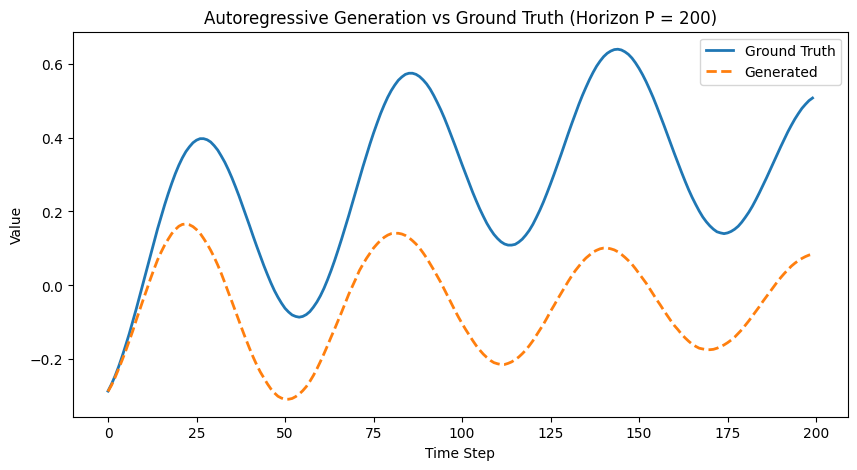

In [65]:
# -------------------------
# Autoregressive Generation and Plotting
# -------------------------
# Switch model to evaluation mode.
transformer_model.eval()

# Set the desired horizon P (number of time steps to generate).
P = 200

# Use the full continuous signal stored in the dataloader.
with torch.no_grad():
    signal = transformer_dataloader.X  # continuous signal from gen_signal
    total_length = signal.numel()
    # Choose a random starting index ensuring we have at least L (history) + P (generation) samples.
    idx = random.randint(0, total_length - L - P)
    # History: the last L values (continuous) as seed.
    history_cont = signal[idx: idx + L]
    # Ground truth for the horizon.
    ground_truth_cont = signal[idx + L: idx + L + P]

    # Tokenize the history as in the dataloader.
    history_token = torch.clamp(history_cont, -2, 2)
    history_token = ((history_token + 2) / 0.001).long().unsqueeze(0).to('cuda')  # shape (1, L)

    generated_tokens = history_token.clone()  # starting sequence

    # Autoregressive generation: for each of the P steps.
    for i in range(P):
        # For generation, use the last L tokens as input.
        if generated_tokens.size(1) > L:
            input_tokens = generated_tokens[:, -L:]
        else:
            input_tokens = generated_tokens
        logits = transformer_model(input_tokens)  # (1, seq_len, vocab_size)
        next_logits = logits[:, -1, :]  # take logits for the last time step: (1, vocab_size)
        # Greedy sampling (argmax).
        next_token = torch.argmax(next_logits, dim=-1, keepdim=True)  # (1, 1)
        generated_tokens = torch.cat([generated_tokens, next_token], dim=1)

    # Extract the generated tokens corresponding to the horizon.
    gen_tokens_horizon = generated_tokens[0, L:]  # shape: (P,)
    # Convert tokens back to continuous values.
    generated_cont = gen_tokens_horizon.float() * 0.001 - 2.0

    # For comparison, convert the ground truth into tokens and back into continuous values.
    ground_truth_tokens = torch.clamp(ground_truth_cont, -2, 2)
    ground_truth_tokens = ((ground_truth_tokens + 2) / 0.001).long()
    ground_truth_cont = ground_truth_tokens.float() * 0.001 - 2.0

# Plot ground truth vs generated sequence.
plt.figure(figsize=(10, 5))
plt.plot(range(P), ground_truth_cont.cpu().numpy(), label="Ground Truth", linewidth=2)
plt.plot(range(P), generated_cont.cpu().numpy(), label="Generated", linestyle="--", linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Autoregressive Generation vs Ground Truth (Horizon P = {})".format(P))
plt.legend()
plt.show()

In [ ]:
from tqdm import trange
# -------------------------
# Evaluation: Calculate MSE and MAE on Test Set
# -------------------------
# Define the forecast horizon and number of test samples.
H_test = 50      # number of autoregressive steps to forecast
N_test = 1000     # number of test samples over which to average the error

mse_total = 0.0
mae_total = 0.0

# Ensure the model is in evaluation mode.
transformer_model.eval()
with torch.no_grad():
    for i in trange(N_test):
        # Use the continuous signal from the dataloader.
        signal = transformer_dataloader.X  # full continuous signal generated earlier
        total_length = signal.numel()

        # Randomly pick a starting index ensuring there are at least L (history) + H_test future steps.
        idx = random.randint(0, total_length - L - H_test)
        # Extract the history and ground truth for H_test steps.
        history_cont = signal[idx: idx + L]
        ground_truth_cont = signal[idx + L: idx + L + H_test]

        # Tokenize the history (clip and discretize as before).
        history_token = torch.clamp(history_cont, -2, 2)
        history_token = ((history_token + 2) / 0.001).long().unsqueeze(0).to('cuda')  # shape: (1, L)

        # Start autoregressive generation with the history as seed.
        generated_tokens = history_token.clone()
        for step in range(H_test):
            # Use the most recent L tokens as input.
            input_tokens = generated_tokens[:, -L:]
            logits = transformer_model(input_tokens)  # (1, seq_len, vocab_size)
            next_logits = logits[:, -1, :]  # logits for the last time step
            # Greedy sampling: choose the token with highest logit.
            next_token = torch.argmax(next_logits, dim=-1, keepdim=True)  # shape: (1, 1)
            generated_tokens = torch.cat([generated_tokens, next_token], dim=1)

        # The forecast tokens are the ones generated beyond the original history.
        forecast_tokens = generated_tokens[0, L:]  # shape: (H_test,)
        # Convert the tokens back to continuous values.
        generated_cont = forecast_tokens.float() * 0.001 - 2.0

        # For consistency, convert the ground truth into tokens and then back to continuous values.
        ground_truth_tokens = torch.clamp(ground_truth_cont, -2, 2)
        ground_truth_tokens = ((ground_truth_tokens + 2) / 0.001).long()
        ground_truth_cont = ground_truth_tokens.float() * 0.001 - 2.0

        # Calculate errors for this test sample.
        mse_sample = ((generated_cont - ground_truth_cont) ** 2).mean().item()
        mae_sample = torch.abs(generated_cont - ground_truth_cont).mean().item()

        mse_total += mse_sample
        mae_total += mae_sample

# Average errors over all test samples.
avg_mse = mse_total / N_test
avg_mae = mae_total / N_test

print(f"Average MSE over {N_test} test samples: {avg_mse:.6f}")
print(f"Average MAE over {N_test} test samples: {avg_mae:.6f}")
